# Vizualise similiraties in word embeddings

Ici, je prends un mot qui a plusieurs sens. Je prends 3 phrases où il a un certain sens, et 3 autres où il a un autre sens. Ensuite j'encode le mot en question pour chacune des phrases (son embedding dépend du contexte), je calcule la similarité entre chacun des embeddings et visualise ça.

# 1. Implementation

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sn
#sn.set(font_scale=1.5, style="whitegrid", font="sans-serif")

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize, ha="center", va="center", fontweight="bold")
        return [tx]
Legend.update_default_handler_map({str : TextHandlerB()})



def encode_words(model_name_or_path, sentences):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='/raid/antoloui/Master-thesis/_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in indexed_tokens]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(indexed_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, um the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, sentences, word_of_interest, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    embeddings = []
    # In each sentence, get the embedding of the word of interest.
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if word_of_interest in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            word_embedding = df.loc[(df['Sentence']==sent) & (df['Token']==word_of_interest), ~df.columns.isin(['Token','Sentence'])].values[0]
            embeddings.append(word_embedding)

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(word_of_interest)
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
       
    return np.array(embeddings)


def compute_cosine_matrix(embeddings):
    """
    """
    matrix = np.zeros((embeddings.shape[0], embeddings.shape[0]))
    for i in range(embeddings.shape[0]):
        for j in range(embeddings.shape[0]):
            #matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
            matrix[i,j] = np.dot(embeddings[i], embeddings[j])/(np.linalg.norm(embeddings[i])*np.linalg.norm(embeddings[j]))
    return matrix


def create_bold_labels(sentences, word_of_interest):
    """
    """
    labels = []
    for sent in sentences:
        labels.append(sent.replace(word_of_interest, r"$\bf{" + "{}".format(word_of_interest) + "}$"))
    return labels


def run(sentences, word_of_interest):
    """
    """
    #--------------
    # Encode words
    #--------------
    print("BERT-base")
    bert_df = encode_words('bert-base-cased', sentences)
    print("NetBERT")
    netbert_df = encode_words('/raid/antoloui/Master-thesis/_models/netbert-final/', sentences)


    #---------------------
    # Get word embeddings
    #---------------------
    bert_embeddings = get_embeddings(bert_df, sentences, word_of_interest, 'bert-base-cased')
    netbert_embeddings = get_embeddings(netbert_df, sentences, word_of_interest, '../_models/netbert-final/')
    
    
    #-------------------------
    # Visualize cosine matrix
    #-------------------------
    bert_matrix = compute_cosine_matrix(bert_embeddings)
    netbert_matrix = compute_cosine_matrix(netbert_embeddings)

    labels = create_bold_labels(sentences, word_of_interest)
    ids = np.arange(1, len(labels)+1)
    bert_cm = pd.DataFrame(bert_matrix, index=ids, columns=ids)
    netbert_cm = pd.DataFrame(netbert_matrix, index=ids, columns=ids)

    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    sn.heatmap(bert_cm, annot=False, cmap="coolwarm", vmin=bert_matrix.min(), vmax=1.0, cbar=True)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20) #weight='semibold'
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20, rotation=0)
    ax1.set_xlabel("(a) BERT results.", fontsize=28, labelpad=20)

    ax2 = fig.add_subplot(1, 2, 2)
    sn.heatmap(netbert_cm, annot=False, cmap="coolwarm", vmin=bert_matrix.min(), vmax=1.0, cbar=True)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20) 
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20, rotation=0)
    ax2.set_xlabel("(b) NetBERT results.", fontsize=28, labelpad=20)
    
    legend = fig.legend(handles=list(map(str, ids)), labels=labels, title='Sentences', fontsize='18', loc='upper center', bbox_to_anchor=(0.5, 1.4))
    legend.get_title().set_fontsize('22') #legend 'Title' fontsize
    legend._legend_box.align = "left"
    fig.tight_layout()
    fig.show()
    fig.savefig("./figures/word_similarity_" + word_of_interest + ".pdf", bbox_inches='tight')
    return

Using TensorFlow backend.


# 2. Tests

### "switch"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 23 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 23 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


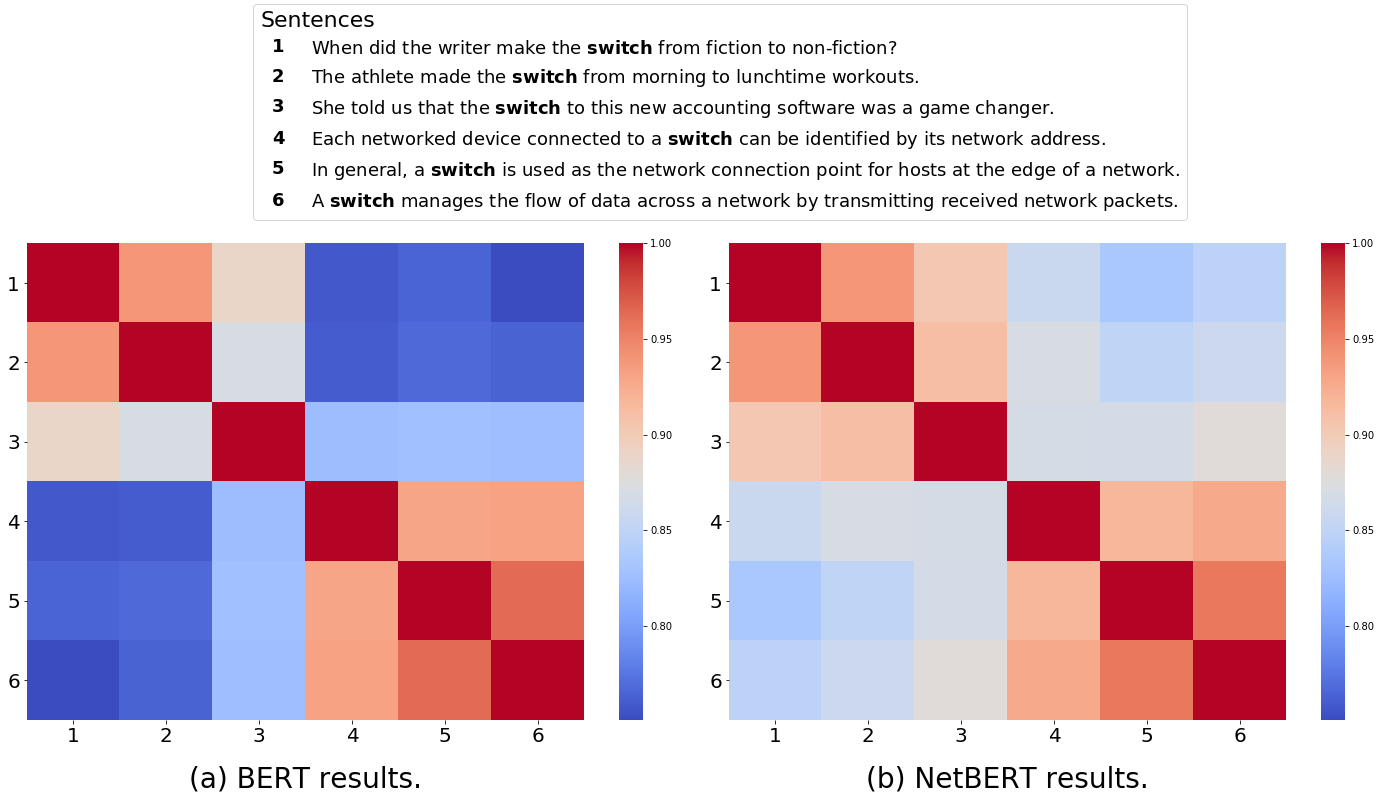

In [4]:
word_of_interest = 'switch'
sentences = ["When did the writer make the switch from fiction to non-fiction?",
             "The athlete made the switch from morning to lunchtime workouts.",
             "She told us that the switch to this new accounting software was a game changer.",
             #"Because the switch acts as the network proxy, the authentication service is transparent to the client.",
             #"Multiple data cables are plugged into a switch to enable communication between different networked devices.",
             "Each networked device connected to a switch can be identified by its network address.",
             #"An Ethernet switch operates at the data link layer (layer 2) of the OSI model.",
             #"You should disconnect the Ethernet cable from the switch port.",
             #"A switch operating as a network bridge may interconnect devices in a home or office.",
             #"A network switch forwards data only to the devices that need to receive it.",
             #"The network switch plays an integral role in most modern Ethernet local area networks.",
             "In general, a switch is used as the network connection point for hosts at the edge of a network.",
             "A switch manages the flow of data across a network by transmitting received network packets.",
             #"The switch supports up to 16 simultaneous Telnet sessions.",
             #"Through port mirroring, a switch can create a mirror image of data that can go to an external device.",
             #"For each VLAN, the switch with the lowest bridge ID becomes the root for that VLAN.",
             #"A switch can be in only one VTP domain.",
             #"The core function of an Ethernet switch is to provide multiport layer-2 bridging.",
             #"A switch normally supports different data rates simultaneously.",
            ]
run(sentences, word_of_interest)

### "bridge"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


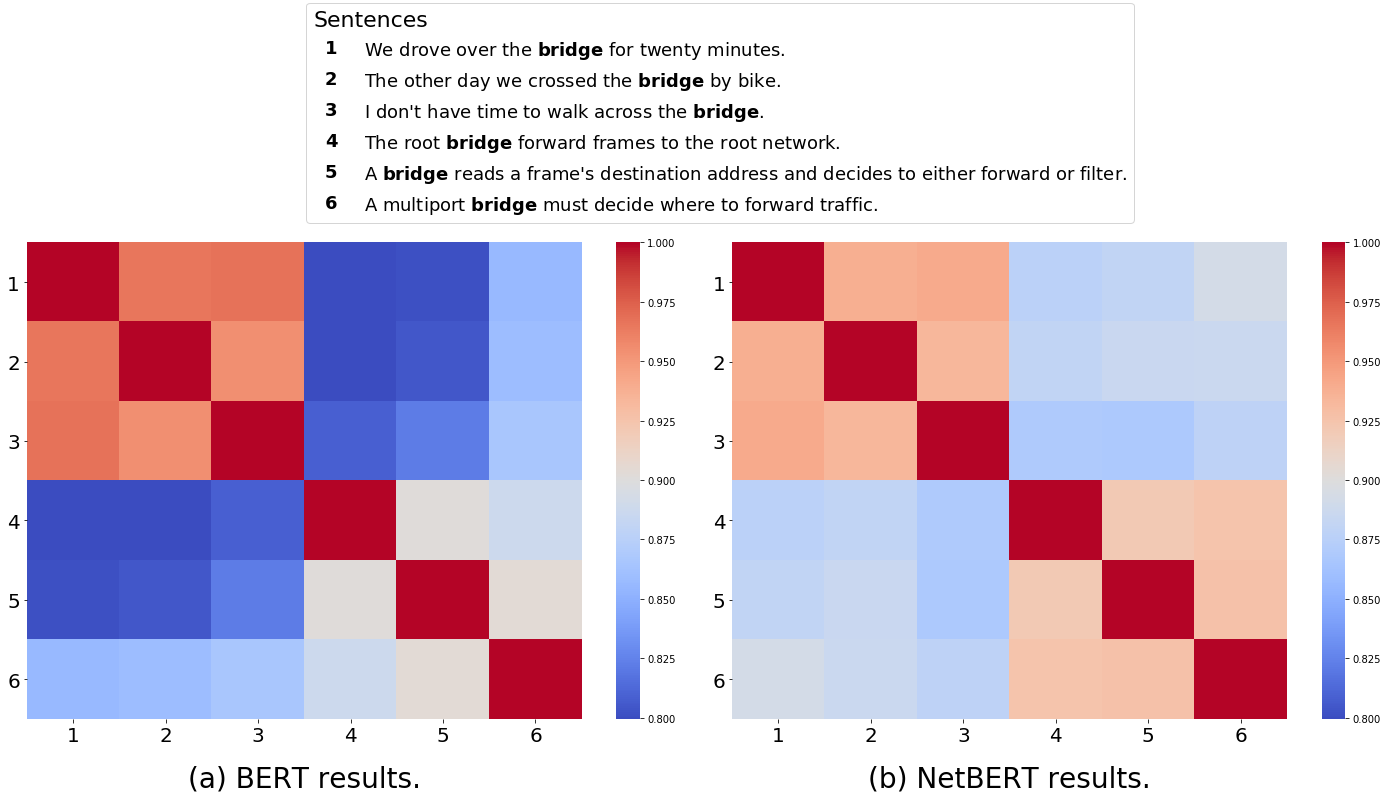

In [10]:
word_of_interest = 'bridge'
sentences = [#"The water under the bridge started to overflow.",
             #"The bridge is not strong enough to bear the weight of more than two vehicles at a time.",
             #"They are building a bridge of stone there.",
             #"This was recognized as the longest bridge in the world.",
             #"It is not safe to cross that wooden bridge.",
             "We drove over the bridge for twenty minutes.",
             #"Within two hours, the bridge was passable.",
             "The other day we crossed the bridge by bike.",
             #"It took us two hours to cross that bridge by bike.",
             #"The fastest way to reach the bank is to cross the bridge.",
             "I don't have time to walk across the bridge.",
             "The root bridge forward frames to the root network.",
             "A bridge reads a frame's destination address and decides to either forward or filter.",
             "A multiport bridge must decide where to forward traffic."]
run(sentences, word_of_interest)

### "port"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 22 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 22 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


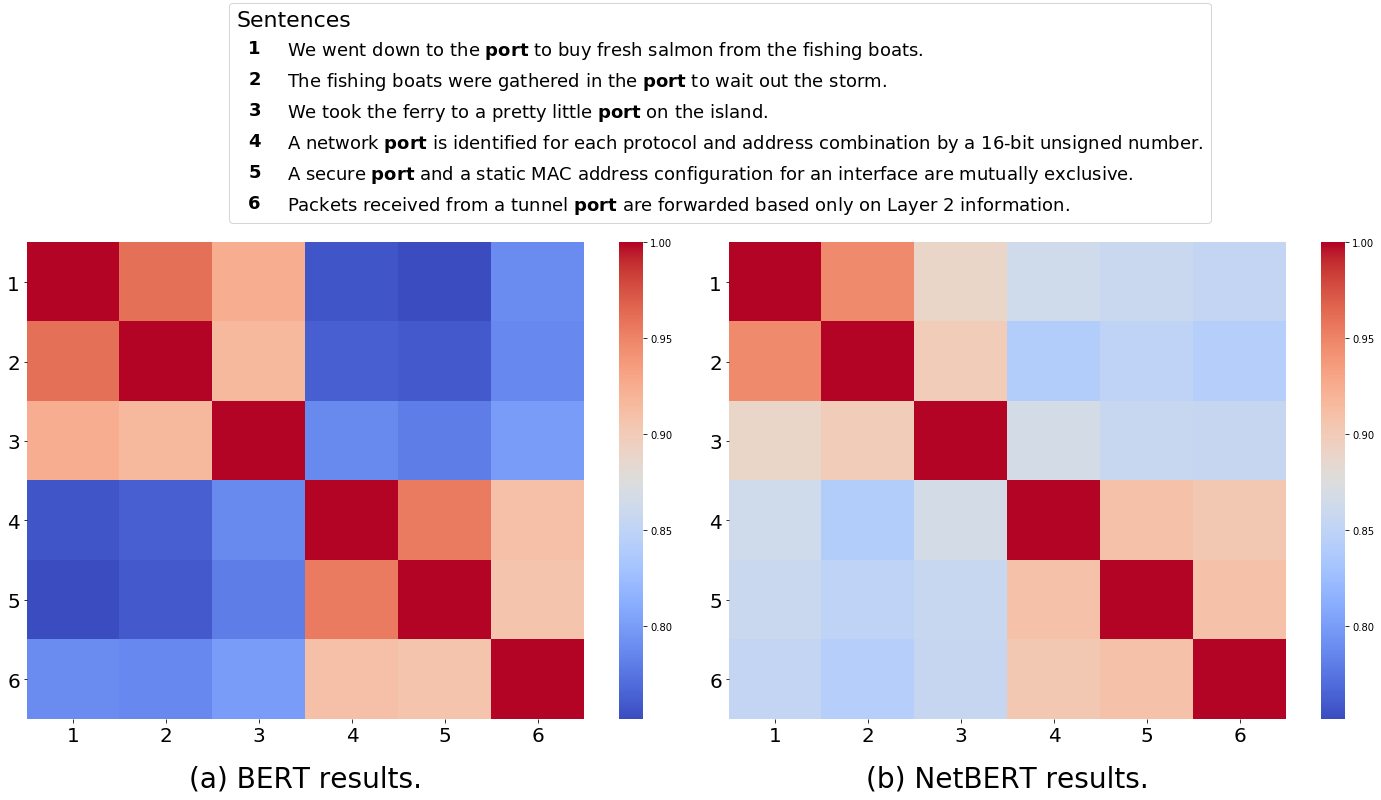

In [11]:
word_of_interest = 'port'
sentences = ["We went down to the port to buy fresh salmon from the fishing boats.",
             "The fishing boats were gathered in the port to wait out the storm.",
             "We took the ferry to a pretty little port on the island.",
             #"In computer networking, a port is a communication endpoint.",
             #"The port can send packets to the host but cannot receive packets from the host.",
             "A network port is identified for each protocol and address combination by a 16-bit unsigned number.",
             "A secure port and a static MAC address configuration for an interface are mutually exclusive.",
             #"A port number is always associated with an IP address of a host and the protocol type of the communication.",
             #"The port number 0 is reserved for TCP and cannot be used.",
             #"All traffic through the single port is available to both access points.",
             #"For TCP, only one process may bind to a specific IP address and port combination.",
             "Packets received from a tunnel port are forwarded based only on Layer 2 information."]
run(sentences, word_of_interest)